# Kernel density estimation method

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

## Importation des bases de données : celles-ci sont construites de la même manière et contiennent les mêmes informations

Chacun des df contient les informations suivantes :

- l'ID du véhicule, qui est unique pour chaque véhicule de chaque peloton ;
- la position du véhicule dans le peloton (1-2-3-4) ;
- le temps de réponse calculé par l'algorithme de détermination des instants de changements de vitesse du laeder puis des suiveurs ;
- l'instant auquel intervient de changement de vitesse (la référence des temps est prise à 0) ;
- le mode de conduite du véhicule (ACC ou CACC ici).

In [2]:
stat_kernel_CARMA = pd.read_csv('stat_kernel_CARMA.csv', sep = ',', decimal = '.', low_memory = False)

In [3]:
stat_kernel_proof = pd.read_csv('stat_kernel_proof.csv', sep = ',', decimal = '.', low_memory = False)

Création du df final qui contient toutes les informations liées aux temps de réponse des bases étudiées.

In [4]:
stat_kernel = pd.DataFrame()
#concaténation des deux df précédents
stat_kernel = pd.concat([stat_kernel_CARMA, stat_kernel_proof])

In [5]:
#refonte des index
stat_kernel = stat_kernel.reset_index(drop = True)

Le principe de cette étude est de déterminer un temps de réponse limite à partir duquel on estime que le véhicule ne se comporte plus en CACC parmi les enregistrements CACC. On raisonne donc par rapport à la position des véhicules dans le peloton.

In [6]:
#création d'un df propre à chaque position dans le peloton
for f in range(1, 5):
    globals()['stat_kernel_f{}'.format(f)] = stat_kernel[stat_kernel.veh_position == f]

In [7]:
#refonte des index
for f in range(1, 5):
    globals()['stat_kernel_f{}'.format(f)] = globals()['stat_kernel_f{}'.format(f)].reset_index(drop = True)

## Kernel density estimation

In [8]:
#on raisonne ainsi pour chacune des positions des véhicules dans le peloton
#dans la méthode kernel, h désigne l'écart-type des distributions normales de moyenne chacune des valeurs de temps de réponse
#la distribution finale est la somme des distributions précédentes, h devient donc un paramètre de celle-ci
#création de H, pour chaque position, la valeur de h est différente
#la valeur de h est prise par calage sur les échantillons :
#plus h est grand, plus la distribution est étalée et inversement
H = [0.15, 0.3, 0.6, 0.7]

In [9]:
#création des plages de données à tracer pour chaque position en fonction des valeurs de temps de réponse obtenues
#les plages de données peuvent être différentes selon les attentes de l'utilisateur
for f in range(1, 5):
    globals()['X{}'.format(f)] = np.linspace(int(min(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode==1].reaction_time)) - 2,\
                                             int(max(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode==1].reaction_time) +\
                                             np.mean(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode==1].reaction_time)), 1000)

In [10]:
#création de la fonction de densité associée à la distribution des temps de réponse
#création d'une fonction de densité qui, pour chacune des valeurs de temps de réponse du df, calcule la densité associée
#de moyenne la valeur et d'écart-type h
#la fonction finale est la somme des fonctions de densité calculées
def densite(valeurs, h, Xf):
    #cette fonction calcule pour chaque élément de Xi, 
    #la somme des distributions normales associées à chacune des valeurs de TR
    Y = np.zeros(len(Xf))
    n = len(valeurs)
    for i in range(len(Xf)):
        Y[i] = 1 / (n * h * np.sqrt(2 * np.pi)) * sum([np.exp(-(Xf[i] - Xi) ** 2\
        / (2 * h ** 2)) for Xi in valeurs])
    return Y

1
2
3
4


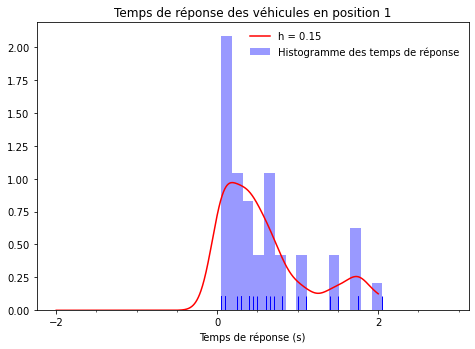

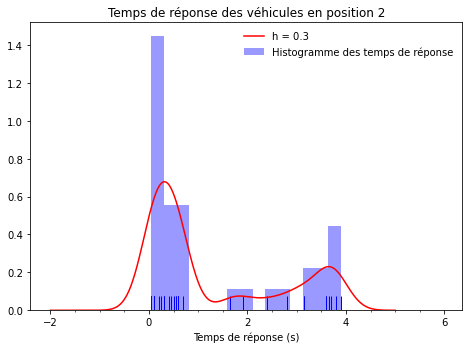

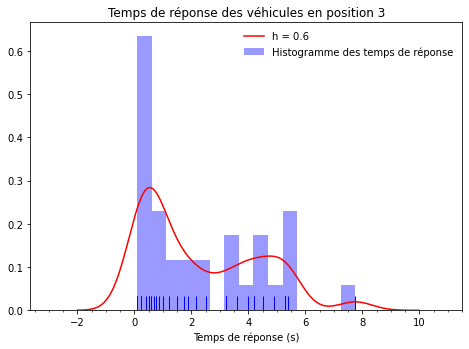

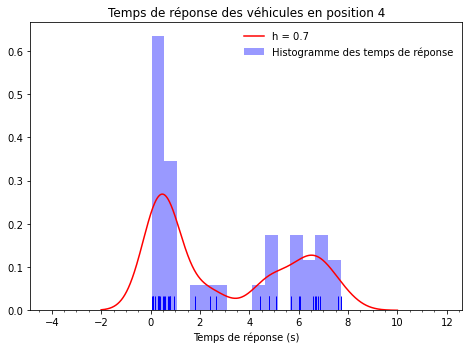

In [11]:
#tracé des distributions et des des fonctions de densité calculées pour chaque position
for f in range(1, 5):
    print(f)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    #distribution des valeurs de temps de réponse
    sns.distplot(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode==1].reaction_time, 15, color='b',\
                 rug=True, kde_kws={'color': 'k', 'lw': 0}, label='Histogramme des temps de réponse')
    #fonction de densité représentée en rouge sur les graphes
    Y = densite(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode==1].reaction_time,\
                H[f - 1], globals()['X{}'.format(f)])
    ax.plot(globals()['X{}'.format(f)], Y, color='r', label="h = " + str(H[f - 1]))
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.set_xlabel("Temps de réponse (s)")
    ax.set_title("Temps de réponse des véhicules en position {}".format(f))
    ax.legend(loc='best', frameon=False)

plt.show()

# Détermination du temps de réponse limite

Pour obtenir des indicateurs chiffrés sur les temps de réponse à l'aide de la methodé kernel, il faut ensuite déterminer un instant qui correspond au temps de réponse limite à partir duquel on considère que le véhicule n'est pas en CACC.

La méthode repose sur l'étude du minimum local obtenu entre les deux pics dont le premier constituerait le mode CACC. Les considérations faites par la suite peuvent être faites dès lors que l'on considère que le premier pic, correspond à une conduite en CACC effective, désigne le mode prépondérant. Le ou les pics suivants représentent ainsi les pics du mode ACC qui sont minoritaires (pas au niveau cumulatif mais fréquentiel). La présence de plusieurs pics pour l'ACC seraitcaractéristique des pelotons mixte dans lesquels certains véhicules fonctionneraient comme des CACC tandis que d'autres comme des ACC.

In [12]:
#trouver le minimum de la fonction de répartition
def min_repartition(stat_kernel, h, Xf):
    Y = densite(stat_kernel, h, Xf)
    #on a besoin du maximum global car le mode CACC est majoritaire
    Y_Max = max(Y)
    x_Max = list(Y).index(Y_Max)
    #on veut trouver le minimum de la fonction de répartition
    #on part du maximum global
    x = x_Max
    #on veut parcourir la liste Xf et travailler avec les variations
    while Y[x + 1] - Y[x] < 0:
        x += 1
    x_Min = x
    Y_Min = Y[x]
    return Xf[x_Min]

La suite de l'étude se fait donc par rapport au temps de réponse limite calculé pour le premier suiveur pour tous les modes confondus. Il sert de référence pour les positions suivantes en partant du principe que tous les suiveurs CACC doivent réagir comme le premier suiveur et donc que le temps de réponse entre tout suiveur et le leader est égal au temps de réponse entre le leader et le premier suiveur. Les fonctions de densité montrent que pour les derniers suiveurs, la démarcation entre le CACC et le reste n'est pas clairement identifiable et que le temps de réponse correspondant au minimum de la fonction de densité est de plus en plus grand.

In [13]:
#définition du facteur de comparaison utilisé pour avoir les proportions de véhicules en CACC parmi l'échantillon CACC
#on prend ce facteur pour tous les TR entre le leader et le premier suiveur car seuls deux évènements sont possibles :
#le F1 est en CACC ou le F1 fonctionne comme un ACC
facteur_comp = min_repartition(globals()['stat_kernel_f{}'.format(1)].reaction_time,\
                                           H[0], globals()['X{}'.format(1)])

In [14]:
#trouver la répartition des valeurs dans les deux intervalles à partir du minimum local
def repartition(stat_kernel, h, Xf, facteur):
    val_CACC = []
    val_ACC = []
    #la ligne ci-dessous est utile si on raisonne différemment pour chaque suiveur
    #ce qui n'est aps le cas ici
    #Y_Min = min_repartition(stat_kernel, h, Xf)
    for val in stat_kernel:
        #si la valeur est supérieure à la valeur du minimum de la fonction, on la considère comme ACC
        if val > facteur:
            val_ACC.append(val)
        #sinon on la considère comme CACC
        elif val < facteur:
            val_CACC.append(val)
    return val_CACC, val_ACC

In [15]:
#trouver la proportion de chacun des modes par position
def mode(stat_kernel, h, Xf, facteur):
    val_CACC, val_ACC = repartition(stat_kernel, h, Xf, facteur)
    return (len(val_CACC)/len(stat_kernel)*100, len(val_ACC)/len(stat_kernel)*100)